In [17]:
import pandas as pd
import io
import time
import requests
from urllib.request import urlopen

# Number of attempts to download data
MAX_ATTEMPTS = 6
# HTTPS here can be problematic for installs that don't have Lets Encrypt CA
SERVICE = "http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"

# url_name = "https://mesonet.agron.iastate.edu/cgi-bin/request/hourlyprecip.py?network=CO_ASOS&station=04V&station=0CO&station=1NW&station=1V6&station=20V&station=2V5&station=2V6&station=33V&station=3MW&station=4BM&station=4V0&station=4V1&station=5SM&station=7BM&station=8V7&station=ABH&station=AEJ&station=AFF&station=AIB&station=AJZ&station=AKO&station=ALS&station=ANK&station=APA&station=ASE&station=BDU&station=BJC&station=BKF&station=C07&station=C08&station=C99&station=CAG&station=CCU&station=CEZ&station=CFO&station=COS&station=CPW&station=CRV&station=CWN&station=DEN&station=DRO&station=EEO&station=EGE&station=EIK&station=FCS&station=FLY&station=FMM&station=FNL&station=FTG&station=GJT&station=GNB&station=GUC&station=GXY&station=HDN&station=HEQ&station=ITR&station=LAA&station=LHX&station=LIC&station=LMO&station=LXV&station=MNH&station=MTJ&station=MYP&station=PSO&station=PUB&station=RCV&station=RIL&station=SBS&station=SHM&station=SPD&station=STK&station=TAD&station=TEX&station=VTP&year1=2024&month1=1&day1=1&year2=2024&month2=1&day2=5&lalo=1&tz=Etc%2FUTC"

In [29]:
def download_data(uri):
    """Fetch the data from the IEM

    The IEM download service has some protections in place to keep the number
    of inbound requests in check.  This function implements an exponential
    backoff to keep individual downloads from erroring.

    Args:
      uri (string): URL to fetch

    Returns:
      string data
    """
    attempt = 0
    while attempt < MAX_ATTEMPTS:
        try:
            data = urlopen(uri, timeout=300).read().decode("utf-8")
            if data is not None and not data.startswith("ERROR"):
                return data
        except Exception as exp:
            print(f"download_data({uri}) failed with {exp}")
            time.sleep(5)
        attempt += 1

    print("Exhausted attempts to download, returning empty data")

In [26]:
station_dict = {}

states = (
    "AK AL AR AZ CA CO CT DE FL GA HI IA ID IL IN KS KY LA MA MD ME MI MN "
    "MO MS MT NC ND NE NH NJ NM NV NY OH OK OR PA RI SC SD TN TX UT VA VT "
    "WA WI WV WY"
)
networks = [f"{state}_ASOS" for state in states.split()]

for network in networks:
    # Get metadata
    uri = "https://mesonet.agron.iastate.edu/" f"geojson/network/{network}.geojson"
    data = urlopen(uri)
    jdict = json.load(data)
    stations = []
    for site in jdict["features"]:
        stations.append(site["properties"]["sid"])
    station_dict[network] = stations

In [28]:
station_dict.keys()

dict_keys(['AK_ASOS', 'AL_ASOS', 'AR_ASOS', 'AZ_ASOS', 'CA_ASOS', 'CO_ASOS', 'CT_ASOS', 'DE_ASOS', 'FL_ASOS', 'GA_ASOS', 'HI_ASOS', 'IA_ASOS', 'ID_ASOS', 'IL_ASOS', 'IN_ASOS', 'KS_ASOS', 'KY_ASOS', 'LA_ASOS', 'MA_ASOS', 'MD_ASOS', 'ME_ASOS', 'MI_ASOS', 'MN_ASOS', 'MO_ASOS', 'MS_ASOS', 'MT_ASOS', 'NC_ASOS', 'ND_ASOS', 'NE_ASOS', 'NH_ASOS', 'NJ_ASOS', 'NM_ASOS', 'NV_ASOS', 'NY_ASOS', 'OH_ASOS', 'OK_ASOS', 'OR_ASOS', 'PA_ASOS', 'RI_ASOS', 'SC_ASOS', 'SD_ASOS', 'TN_ASOS', 'TX_ASOS', 'UT_ASOS', 'VA_ASOS', 'VT_ASOS', 'WA_ASOS', 'WI_ASOS', 'WV_ASOS', 'WY_ASOS'])

In [49]:
state = "CO"
network = f"{state}_ASOS"
start_year = 2022
end_year = 2024
start_month = 1
end_month = 12
start_day = 1
end_day = 31

station_str = ""
for station in station_dict[network]:
    station_str += f"&station={station}"

url_name = f"https://mesonet.agron.iastate.edu/cgi-bin/request/hourlyprecip.py?network={network}{station_str}&year1={start_year}&month1={start_month}&day1={start_day}&year2={end_year}&month2={end_month}&day2={end_day}&lalo=1&tz=Etc%2FUTC"

data = download_data(url_name)

In [ ]:
df = pd.read_csv(io.StringIO(data))
df

,station,network,valid,precip_in,lat,lon
0,1NW,CO_ASOS,2024-01-01 00:00,0.0,40.631900,-103.837100
1,ALS,CO_ASOS,2024-01-01 00:00,0.0,37.438890,-105.861390
2,C08,CO_ASOS,2024-01-01 00:00,0.0,38.013278,-105.374272
3,CAG,CO_ASOS,2024-01-01 00:00,0.0,40.495220,-107.521650
4,4V0,CO_ASOS,2024-01-01 00:00,0.0,40.095600,-108.759300
...,...,...,...,...,...,...
394210,LMO,CO_ASOS,2024-09-03 17:00,0.0,40.163670,-105.163040
394211,RCV,CO_ASOS,2024-09-03 17:00,0.0,37.713800,-106.352000
394212,2V5,CO_ASOS,2024-09-03 17:00,0.0,40.100323,-102.240960
394213,2V6,CO_ASOS,2024-09-03 17:00,0.0,40.104600,-102.712800


<Axes: xlabel='station'>

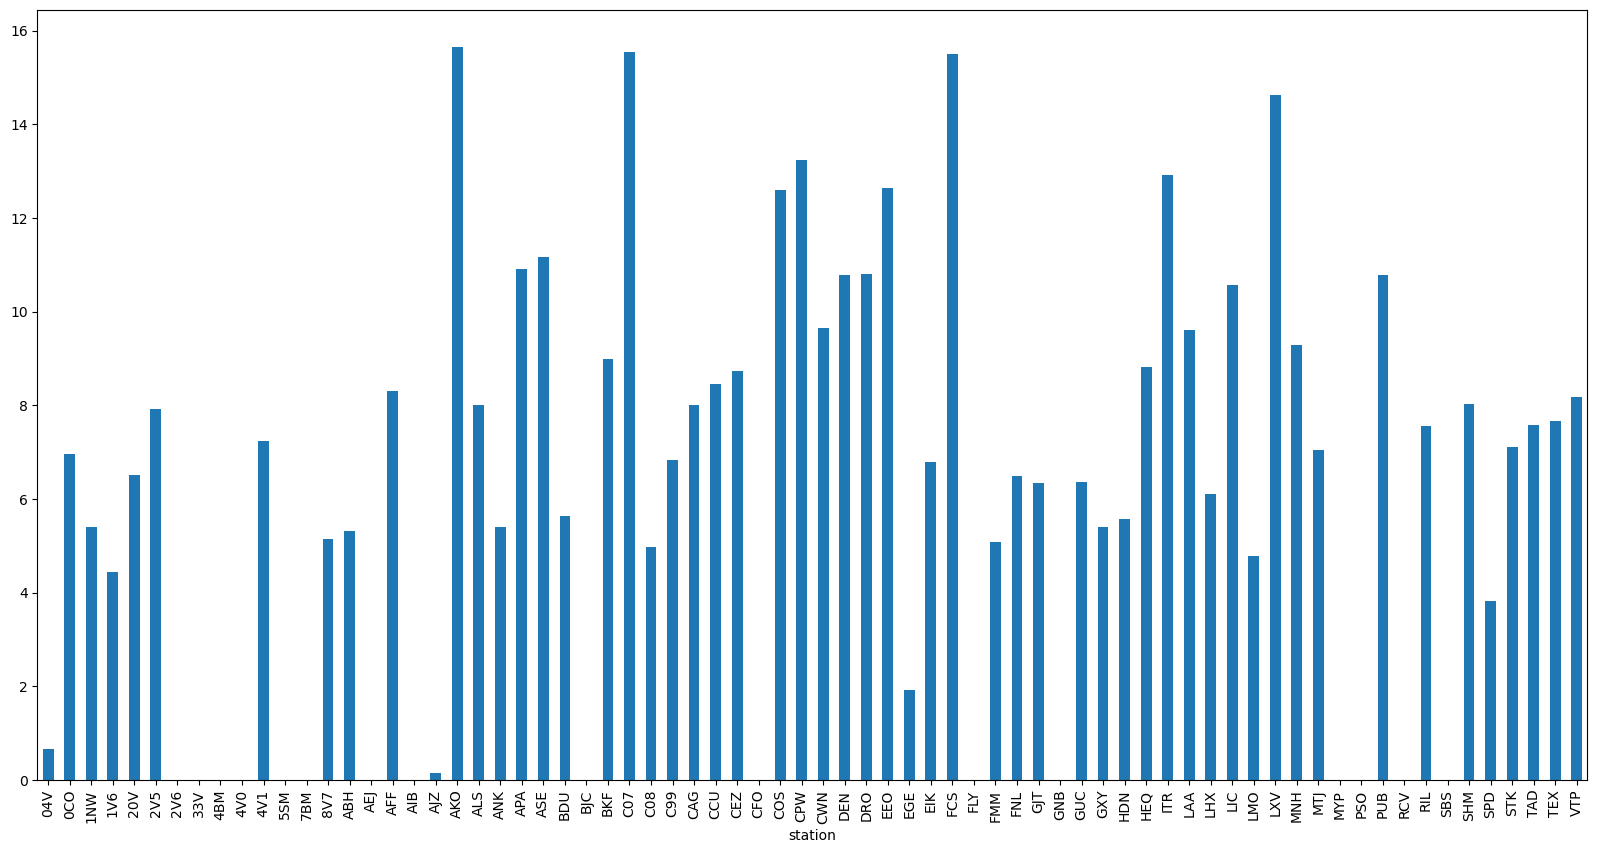

In [48]:
df.groupby("station").sum()["precip_in"].plot(kind="bar", figsize=(20, 10))

In [9]:
data = download_data(url_name)
data

outfn = f"../sample_data/sample_hourly.txt"
with open(outfn, "w", encoding="ascii") as fh:
    fh.write(data)

In [11]:
df = pd.read_csv(outfn)

In [12]:
df

,station,network,valid,precip_in,lat,lon
0,EEO,CO_ASOS,2024-01-01 00:00,0.0000,40.048800,-107.885920
1,7BM,CO_ASOS,2024-01-01 00:00,0.0000,38.782500,-106.218060
2,AJZ,CO_ASOS,2024-01-01 00:00,0.0000,38.786417,-108.063611
3,CPW,CO_ASOS,2024-01-01 00:00,0.0000,37.450000,-106.800000
4,VTP,CO_ASOS,2024-01-01 00:00,0.0000,37.500660,-105.166830
...,...,...,...,...,...,...
6698,2V6,CO_ASOS,2024-01-04 23:00,0.0000,40.104600,-102.712800
6699,LAA,CO_ASOS,2024-01-04 23:00,0.0001,38.070000,-102.688060
6700,DRO,CO_ASOS,2024-01-04 23:00,0.0000,37.151520,-107.753770
6701,COS,CO_ASOS,2024-01-04 23:00,0.0100,38.805810,-104.700780


In [15]:
df = pd.read_csv(io.StringIO(data))
df

,station,network,valid,precip_in,lat,lon
0,EEO,CO_ASOS,2024-01-01 00:00,0.0000,40.048800,-107.885920
1,7BM,CO_ASOS,2024-01-01 00:00,0.0000,38.782500,-106.218060
2,AJZ,CO_ASOS,2024-01-01 00:00,0.0000,38.786417,-108.063611
3,CPW,CO_ASOS,2024-01-01 00:00,0.0000,37.450000,-106.800000
4,VTP,CO_ASOS,2024-01-01 00:00,0.0000,37.500660,-105.166830
...,...,...,...,...,...,...
6698,2V6,CO_ASOS,2024-01-04 23:00,0.0000,40.104600,-102.712800
6699,LAA,CO_ASOS,2024-01-04 23:00,0.0001,38.070000,-102.688060
6700,DRO,CO_ASOS,2024-01-04 23:00,0.0000,37.151520,-107.753770
6701,COS,CO_ASOS,2024-01-04 23:00,0.0100,38.805810,-104.700780


In [ ]:
https://mesonet.agron.iastate.edu/cgi-bin/request/hourlyprecip.py?network=CO_ASOS&station=APA&station=BJC&year1=2024&month1=1&day1=1&year2=2024&month2=9&day2=3&lalo=1&tz=Etc%2FUTC